# Data Preprocessing and Exploratory Data Analysis (EDA)
# Research Notebook for Melbourne Air Quality Project

## Overview

This notebook serves as the core data processing and analysis engine for the project. Its primary responsibilities are:
1.  **Ingestion & Cleaning**: Load the raw, hourly datasets for air quality and weather.
2.  **Exploratory Data Analysis (EDA)**: Conduct a deep-dive analysis using advanced visualizations to understand trends, seasonality, correlations, and geospatial patterns.
3.  **Feature Engineering**: Create meaningful features, including a calculated Air Quality Index (AQI) based on pollutant levels and a User Observations Index (UOI) from social media.
4.  **Aggregation & Merging**: Combine all data sources into a single, analysis-ready hourly dataset.
5.  **Output**: Produce clean, processed datasets (`processed` tier) and a final, feature-rich dataset (`gold` tier) for the modeling phase.

This notebook embodies the principle that **thorough EDA is crucial for effective preprocessing and robust modeling**.

## 1. Environment Setup & Data Loading

In [22]:
# =============================================================================
# CELL 1: SETUP, IMPORTS, AND LOGGER CONFIGURATION
# =============================================================================
import os
import sys
import pandas as pd
import numpy as np
import json
import logging
from glob import glob
import pytz

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import missingno as msno
from wordcloud import WordCloud

# --- 1. Logger Setup (Consistent with Project Standards) ---
def setup_logger(log_file='logs/04_preprocessing_and_eda.log', level=logging.INFO):
    os.makedirs(os.path.dirname(log_file), exist_ok=True)
    logger = logging.getLogger()
    logger.setLevel(level)
    if logger.hasHandlers(): logger.handlers.clear()
    console_handler = logging.StreamHandler(sys.stdout)
    console_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))
    file_handler = logging.FileHandler(log_file, mode='w', encoding='utf-8')
    file_handler.setFormatter(logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s'))
    logger.addHandler(console_handler)
    logger.addHandler(file_handler)
    return logger

logger = setup_logger()

# --- 2. Plotting Style Configuration ---
sns.set_theme(style="whitegrid", palette="pastel")
px.defaults.template = "plotly_white"
logger.info("📊 Plotting styles configured for Seaborn and Plotly.")

# --- 3. Define Paths and Constants ---
# Note: Paths are relative to the 'notebooks' directory.
RAW_DATA_PATH = "../../data/raw/"
PROCESSED_DATA_PATH = "../../data/processed/"
GOLD_DATA_PATH = "../../data/gold/"
os.makedirs(PROCESSED_DATA_PATH, exist_ok=True)
os.makedirs(GOLD_DATA_PATH, exist_ok=True)

# Air Quality Index breakpoints (based on the provided image)
AQI_BREAKPOINTS = {
    'so2': [20, 80, 250, 350],
    'no2': [40, 70, 150, 200],
    'pm10': [20, 50, 100, 200],
    'pm2_5': [10, 25, 50, 75],
    'o3': [60, 100, 140, 180],
    'co': [4400, 9400, 12400, 15400]
}
logger.info("🗂️ Paths and constants defined.")

# --- 4. Load Raw Datasets ---
try:
    # Find the latest files to avoid manual path changes
    air_quality_file = glob(os.path.join(RAW_DATA_PATH, 'melbourne_raw_air_quality*.csv'))[0]
    weather_file = glob(os.path.join(RAW_DATA_PATH, 'melbourne_raw_weather*.csv'))[0]
    social_media_files = glob(os.path.join(RAW_DATA_PATH, 'social_media', '*.json'))

    df_aq = pd.read_csv(air_quality_file)
    df_weather = pd.read_csv(weather_file)
    
    logger.info(f"✅ Loaded Air Quality data: {df_aq.shape} from {os.path.basename(air_quality_file)}")
    logger.info(f"✅ Loaded Weather data: {df_weather.shape} from {os.path.basename(weather_file)}")
    logger.info(f"✅ Found {len(social_media_files)} social media data files.")
except IndexError:
    logger.critical("❌ CRITICAL: Raw data files not found. Please run the data collection notebooks first.")
except Exception as e:
    logger.critical(f"❌ CRITICAL: Failed to load raw data. Error: {e}")

2025-06-21 04:12:56,609 - INFO - 📊 Plotting styles configured for Seaborn and Plotly.
2025-06-21 04:12:56,611 - INFO - 🗂️ Paths and constants defined.
2025-06-21 04:12:58,467 - INFO - ✅ Loaded Air Quality data: (823009, 14) from melbourne_raw_air_quality_openweather_20201125_to_20250104.csv
2025-06-21 04:12:58,468 - INFO - ✅ Loaded Weather data: (829104, 7) from melbourne_raw_weather_openmeteo_2020-11-25_to_2025-01-04.csv
2025-06-21 04:12:58,469 - INFO - ✅ Found 5 social media data files.


## 2. Common Preprocessing: Datetime Conversion & Indexing

The first step is to ensure both datasets have a consistent, timezone-aware datetime index. This is fundamental for time-series analysis and merging.

In [23]:
# =============================================================================
# CELL 2 (FINAL REVISION 5): UTC-first Conversion Strategy
# =============================================================================

def standardize_datetime_via_utc(df: pd.DataFrame, df_name: str, time_col: str, timezone: str = 'Australia/Melbourne') -> pd.DataFrame:
    """
    The most definitive method to handle problematic DST transitions.
    It localizes to UTC first (which never fails), then converts to the target timezone.
    
    Strategy:
    1. Convert column to naive datetime objects.
    2. Localize the naive datetime to UTC.
    3. Convert the UTC-aware datetime to the target Melbourne timezone.
    4. Set the final, correct, timezone-aware index.
    """
    logger.info(f"Applying UTC-first standardization for '{df_name}' (shape: {df.shape})...")

    # 1. Convert to naive datetime objects and remove any parsing errors
    df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
    df.dropna(subset=[time_col], inplace=True)
    
    # 2. Localize to UTC (this step is guaranteed to not fail as UTC has no DST)
    logger.info("Step 1: Localizing to UTC...")
    df[time_col] = df[time_col].dt.tz_localize('UTC', ambiguous='raise', nonexistent='raise')
    
    # 3. Convert from UTC to the target Melbourne timezone
    logger.info(f"Step 2: Converting from UTC to '{timezone}'...")
    df[time_col] = df[time_col].dt.tz_convert(timezone)

    # 4. Set the final, correct index
    df.set_index(time_col, inplace=True)
    
    logger.info(f"Datetime index for '{df_name}' set successfully via UTC conversion.")
    return df

# --- Execution Block ---
try:
    # We no longer need to group by location for this method, simplifying the call.
    if 'df_aq' in locals() and not df_aq.empty:
        logger.info("Processing Air Quality DataFrame (df_aq)...")
        # Let's also drop duplicates here as it's good practice
        df_aq.drop_duplicates(subset=['datetime', 'location'], keep='first', inplace=True)
        df_aq = standardize_datetime_via_utc(df_aq, df_name="df_aq", time_col='datetime')
        if df_aq is not None:
             display(df_aq.head())
    else:
        logger.error("❌ DataFrame 'df_aq' is not found or is empty.")

    if 'df_weather' in locals() and not df_weather.empty:
        logger.info("Processing Weather DataFrame (df_weather)...")
        df_weather.drop_duplicates(subset=['datetime', 'location'], keep='first', inplace=True)
        df_weather = standardize_datetime_via_utc(df_weather, df_name="df_weather", time_col='datetime')
        if df_weather is not None:
            display(df_weather.head())
    else:
        logger.error("❌ DataFrame 'df_weather' is not found or is empty.")

except Exception as e:
    logger.critical(f"A critical error occurred in the execution block: {e}", exc_info=True)

2025-06-21 04:13:00,152 - INFO - Processing Air Quality DataFrame (df_aq)...
2025-06-21 04:13:00,451 - INFO - Applying UTC-first standardization for 'df_aq' (shape: (816247, 14))...
2025-06-21 04:13:00,774 - INFO - Step 1: Localizing to UTC...
2025-06-21 04:13:00,780 - INFO - Step 2: Converting from UTC to 'Australia/Melbourne'...
2025-06-21 04:13:00,785 - INFO - Datetime index for 'df_aq' set successfully via UTC conversion.


location  latitude  longitude  timestamp_unix  \
datetime                                                                        
2020-11-25 19:00:00+11:00  Melbourne CBD  -37.8136   144.9631      1606266000   
2020-11-25 20:00:00+11:00  Melbourne CBD  -37.8136   144.9631      1606269600   
2020-11-25 21:00:00+11:00  Melbourne CBD  -37.8136   144.9631      1606273200   
2020-11-25 22:00:00+11:00  Melbourne CBD  -37.8136   144.9631      1606276800   
2020-11-25 23:00:00+11:00  Melbourne CBD  -37.8136   144.9631      1606280400   

                           aqi      co    no   no2     o3   so2  pm2_5  pm10  \
datetime                                                                       
2020-11-25 19:00:00+11:00    2  220.30  1.87  6.51  85.12  7.15   4.94  6.50   
2020-11-25 20:00:00+11:00    1  213.62  1.22  4.16  78.68  5.07   3.25  4.26   
2020-11-25 21:00:00+11:00    1  213.62  1.05  3.81  77.96  4.65   2.91  3.87   
2020-11-25 22:00:00+11:00    2  216.96  1.02  4.03  80.82  4.95   2.95  3.90   
2020-11-25 23:00:00+11:00    2  226.97  1.12  5.23  90.84  6.20   3.61  4.64   

                            nh3  
datetime                         
2020-11-25 19:00:00+11:00  2.19  
2020-11-25 20:00:00+11:00  1.54  
2020-11-25 21:00:00+11:00  1.44  
2020-11-25 22:00:00+11:00  1.46  
2020-11-25 23:00:00+11:00  1.66

2025-06-21 04:13:00,799 - INFO - Processing Weather DataFrame (df_weather)...
2025-06-21 04:13:01,093 - INFO - Applying UTC-first standardization for 'df_weather' (shape: (829104, 7))...
2025-06-21 04:13:01,372 - INFO - Step 1: Localizing to UTC...
2025-06-21 04:13:01,378 - INFO - Step 2: Converting from UTC to 'Australia/Melbourne'...
2025-06-21 04:13:01,384 - INFO - Datetime index for 'df_weather' set successfully via UTC conversion.


location  temperature  humidity  \
datetime                                                          
2020-11-25 11:00:00+11:00  Melbourne CBD         15.1        87   
2020-11-25 12:00:00+11:00  Melbourne CBD         14.1        90   
2020-11-25 13:00:00+11:00  Melbourne CBD         14.4        90   
2020-11-25 14:00:00+11:00  Melbourne CBD         12.6        97   
2020-11-25 15:00:00+11:00  Melbourne CBD         11.7        99   

                           precipitation  pressure  wind_speed  
datetime                                                        
2020-11-25 11:00:00+11:00            0.0    1010.9         4.2  
2020-11-25 12:00:00+11:00            0.0    1010.2         5.1  
2020-11-25 13:00:00+11:00            0.0    1009.8         0.4  
2020-11-25 14:00:00+11:00            0.0    1009.6         3.1  
2020-11-25 15:00:00+11:00            0.0    1009.5         4.5

## 3. Air Quality Data - EDA & Preprocessing (Hourly)

We will now deeply explore the air quality data to understand its characteristics before cleaning it.

In [24]:
# =============================================================================
# CELL 3.1: EDA - Overall Time Series Trends
# =============================================================================
logger.info("EDA 3.1: Analyzing overall PM2.5 trends over time.")

# Calculate hourly average across all locations
hourly_avg_pm25 = df_aq['pm2_5'].resample('H').mean()

fig = px.line(hourly_avg_pm25, 
              title='<b>Hourly Average PM2.5 Concentration Across All Melbourne Stations (2020-2025)</b>',
              labels={'value': 'PM2.5 (µg/m³)', 'datetime': 'Date'},
              template='plotly_white')

fig.update_layout(
    title_x=0.5,
    xaxis_title='Time',
    yaxis_title='Average PM2.5 (µg/m³)',
    showlegend=False
)
fig.show()

logger.info("Insight: The line chart helps identify major pollution events, such as large spikes during bushfire seasons, and observe long-term trends.")

2025-06-21 04:13:47,383 - INFO - EDA 3.1: Analyzing overall PM2.5 trends over time.


2025-06-21 04:13:55,871 - INFO - Insight: The line chart helps identify major pollution events, such as large spikes during bushfire seasons, and observe long-term trends.


2025-06-21 04:14:04,503 - INFO - EDA 3.2: Analyzing seasonal and daily patterns.
2025-06-21 04:14:05,182 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-21 04:14:05,675 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


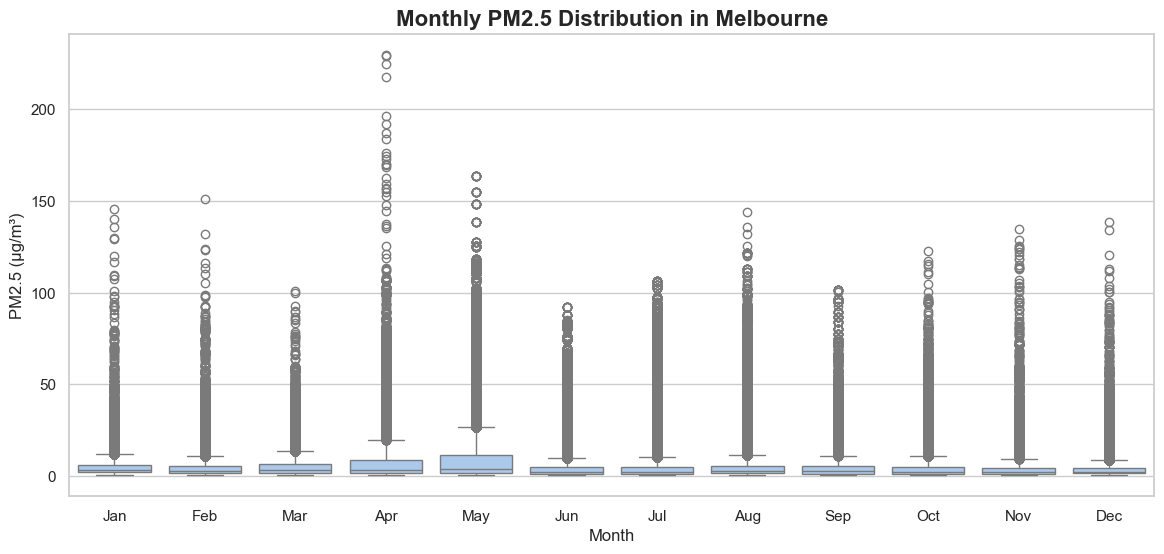

2025-06-21 04:14:06,201 - INFO - Insight (Month): Higher PM2.5 levels and variability are often observed during summer months (Dec-Feb) due to bushfires.
2025-06-21 04:14:06,835 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-21 04:14:07,279 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


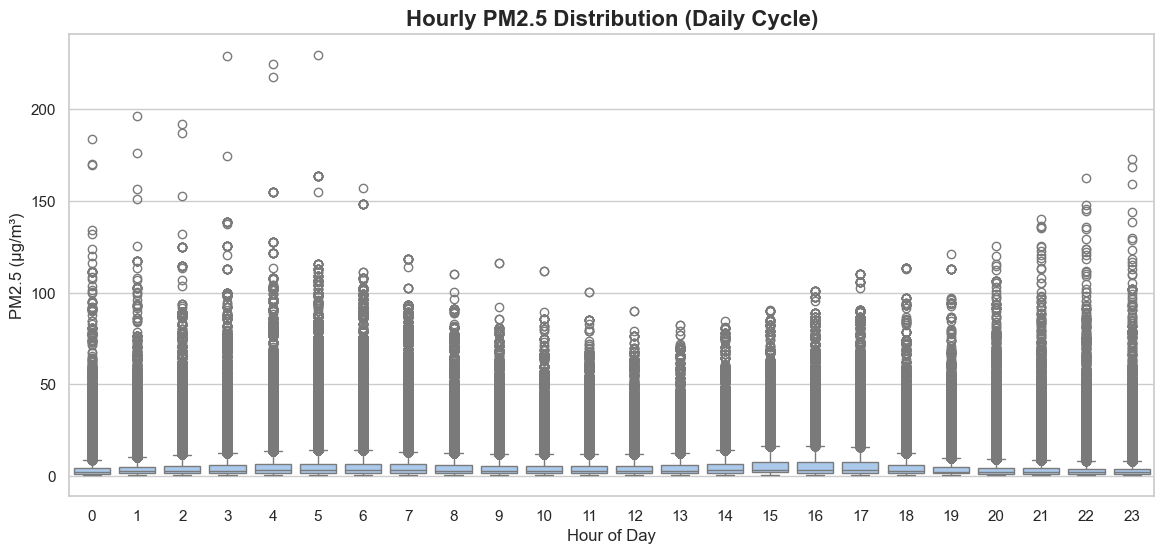

2025-06-21 04:14:07,971 - INFO - Insight (Hour): This reveals diurnal patterns, typically showing peaks during morning and evening rush hours due to traffic.


In [25]:
# =============================================================================
# CELL 3.2: EDA - Seasonal and Cyclical Patterns
# =============================================================================
logger.info("EDA 3.2: Analyzing seasonal and daily patterns.")

# a) Box Plot by Month
fig_month = plt.figure(figsize=(14, 6))
sns.boxplot(x=df_aq.index.month, y='pm2_5', data=df_aq)
plt.title('Monthly PM2.5 Distribution in Melbourne', fontsize=16, weight='bold')
plt.xlabel('Month')
plt.ylabel('PM2.5 (µg/m³)')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()
logger.info("Insight (Month): Higher PM2.5 levels and variability are often observed during summer months (Dec-Feb) due to bushfires.")

# b) Box Plot by Hour
fig_hour = plt.figure(figsize=(14, 6))
sns.boxplot(x=df_aq.index.hour, y='pm2_5', data=df_aq)
plt.title('Hourly PM2.5 Distribution (Daily Cycle)', fontsize=16, weight='bold')
plt.xlabel('Hour of Day')
plt.ylabel('PM2.5 (µg/m³)')
plt.show()
logger.info("Insight (Hour): This reveals diurnal patterns, typically showing peaks during morning and evening rush hours due to traffic.")

2025-06-21 04:14:22,313 - INFO - EDA 3.3: Analyzing geospatial pollution distribution.


2025-06-21 04:14:22,650 - INFO - Insight (Map): The map visually identifies pollution hotspots. Larger, redder circles indicate areas with consistently higher average pollution.


C:\Users\Le Nguyen Gia Hung\AppData\Local\Temp\ipykernel_8392\1014028180.py:31: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




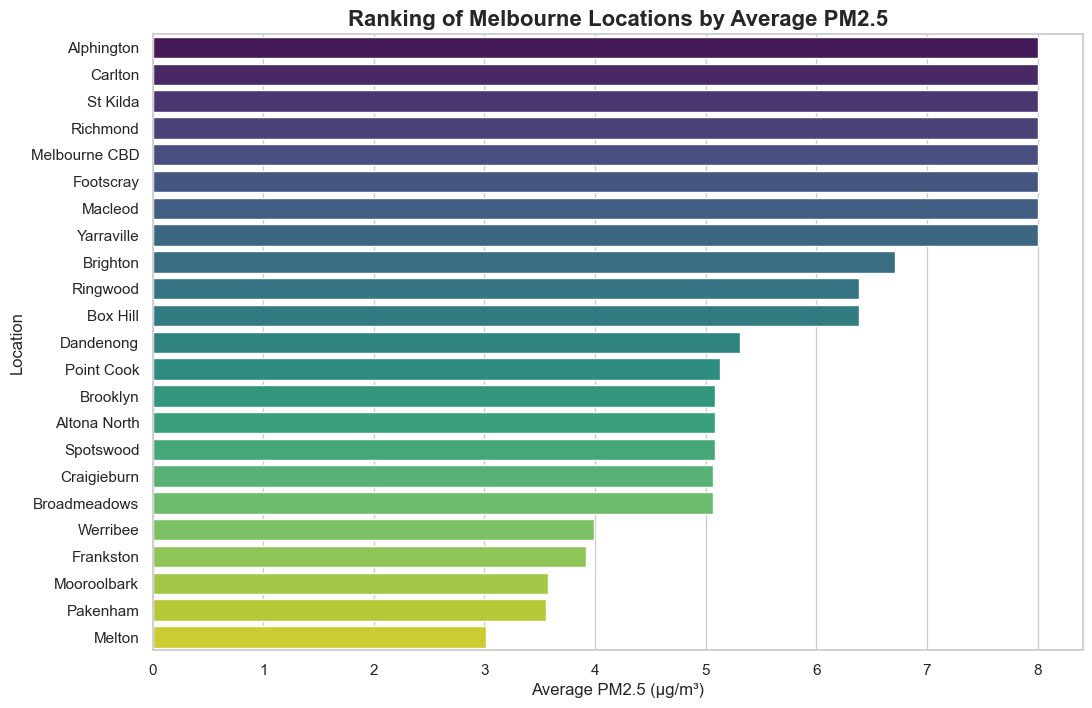

2025-06-21 04:14:23,139 - INFO - Insight (Ranking): This chart provides a clear, quantitative ranking of the most and least polluted sites, useful for resource allocation.


In [26]:
# =============================================================================
# CELL 3.3: EDA - Geospatial Analysis
# =============================================================================
logger.info("EDA 3.3: Analyzing geospatial pollution distribution.")

# Calculate average PM2.5 for each location
location_avg = df_aq.groupby('location')[['latitude', 'longitude', 'pm2_5']].mean().reset_index()

# a) Interactive Map of Pollution Hotspots
fig_map = px.scatter_mapbox(
    location_avg,
    lat="latitude",
    lon="longitude",
    size="pm2_5",
    color="pm2_5",
    hover_name="location",
    hover_data={'pm2_5': ':.2f', 'latitude': False, 'longitude': False},
    color_continuous_scale=px.colors.sequential.YlOrRd,
    size_max=15,
    zoom=9,
    mapbox_style="carto-positron",
    title="<b>Average PM2.5 Concentration by Monitoring Location</b>"
)
fig_map.update_layout(title_x=0.5, margin={"r":0,"t":40,"l":0,"b":0})
fig_map.show()
logger.info("Insight (Map): The map visually identifies pollution hotspots. Larger, redder circles indicate areas with consistently higher average pollution.")

# b) Bar Chart Ranking Locations
top_polluted = location_avg.sort_values('pm2_5', ascending=False)
fig_bar = plt.figure(figsize=(12, 8))
sns.barplot(x='pm2_5', y='location', data=top_polluted, palette='viridis')
plt.title('Ranking of Melbourne Locations by Average PM2.5', fontsize=16, weight='bold')
plt.xlabel('Average PM2.5 (µg/m³)')
plt.ylabel('Location')
plt.show()
logger.info("Insight (Ranking): This chart provides a clear, quantitative ranking of the most and least polluted sites, useful for resource allocation.")

2025-06-21 04:14:56,651 - INFO - PREPROCESSING 3.4: Analyzing and handling missing values.


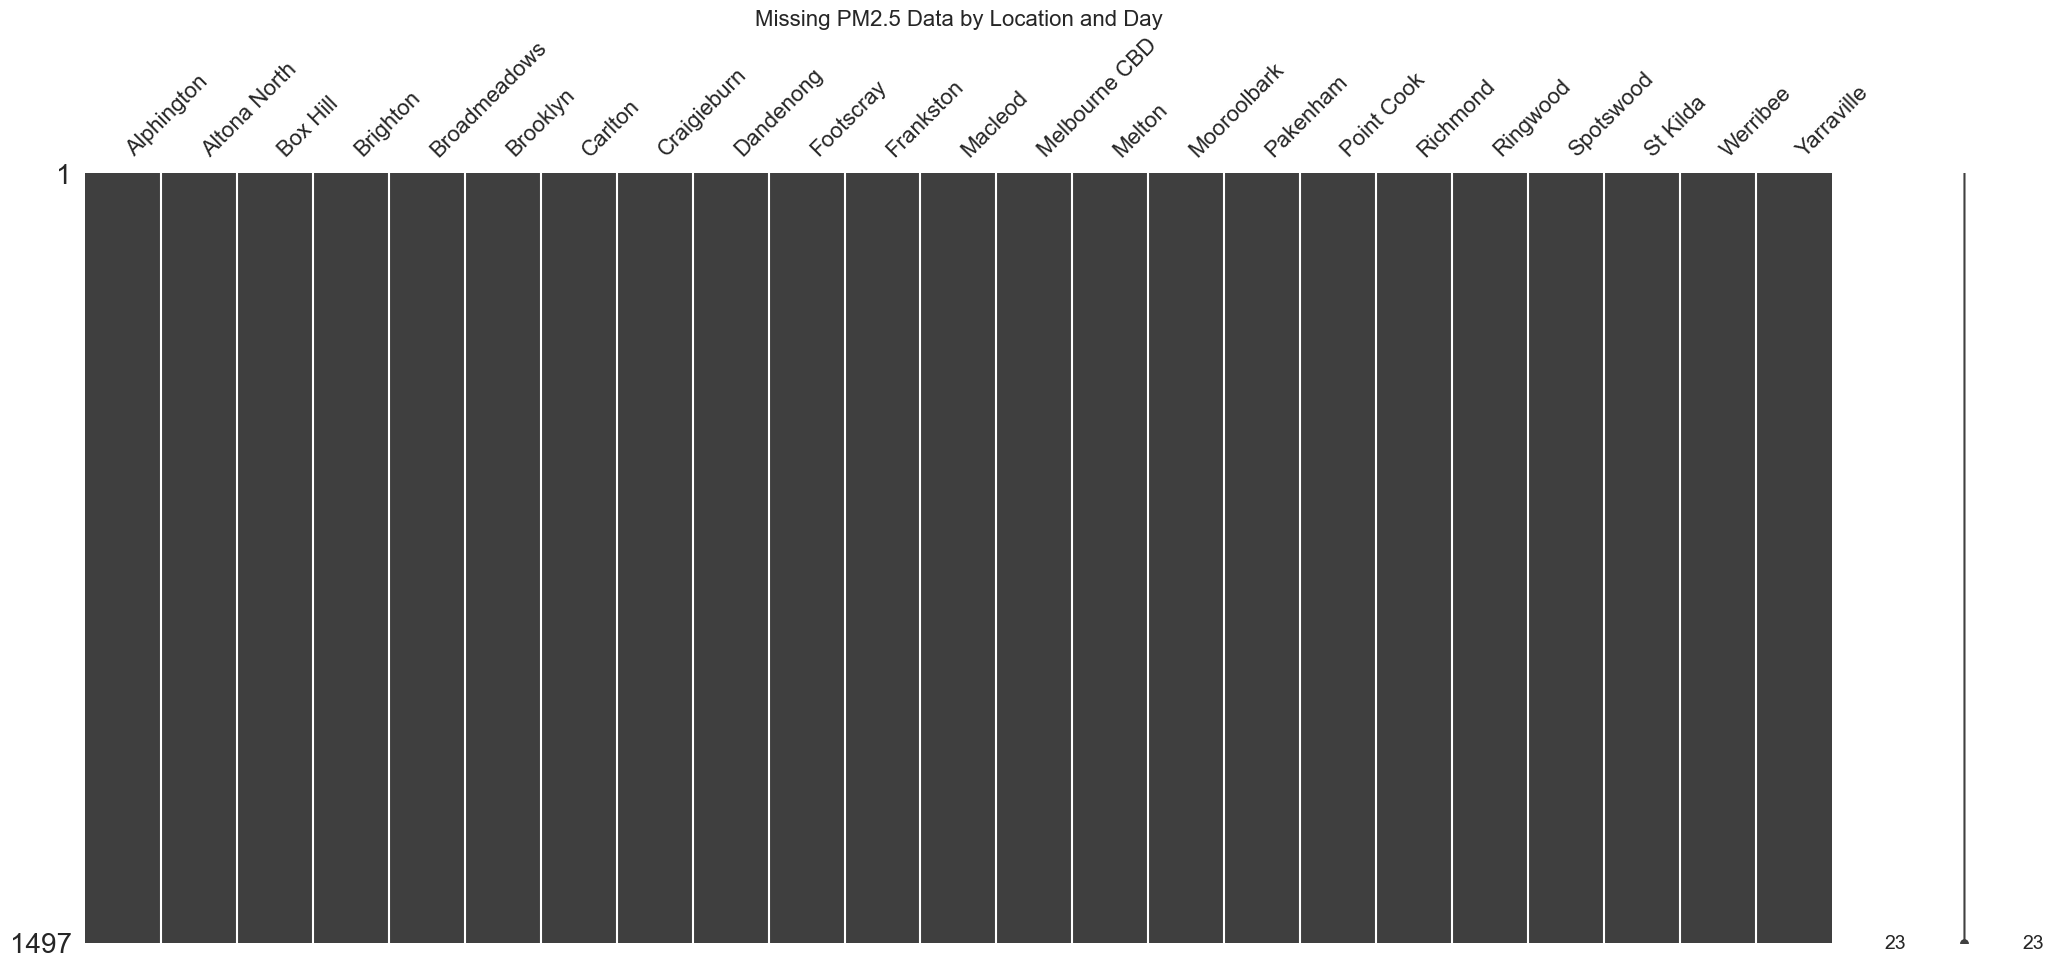

2025-06-21 04:14:57,423 - INFO - Insight (Missingno): White lines indicate missing data. This helps check if data loss is random or systematic (e.g., a specific station offline for a week).
2025-06-21 04:14:57,837 - INFO - Imputation complete. Missing values reduced from 0 to 0.
2025-06-21 04:14:57,882 - INFO - Dataframe shape after imputation and final drop: (816247, 13)


In [27]:
# =============================================================================
# CELL 3.4: Preprocessing - Missing Values Analysis & Imputation
# =============================================================================
logger.info("PREPROCESSING 3.4: Analyzing and handling missing values.")

# a) Visualize Missing Data
# The matrix plot is excellent for spotting patterns in missing data.
msno.matrix(df_aq.pivot_table(values='pm2_5', index=df_aq.index.date, columns='location'))
plt.title('Missing PM2.5 Data by Location and Day', fontsize=16)
plt.show()
logger.info("Insight (Missingno): White lines indicate missing data. This helps check if data loss is random or systematic (e.g., a specific station offline for a week).")

# b) Imputation Strategy: Forward Fill and Backward Fill
# For time-series, interpolating or ffill/bfill is common. We'll use ffill then bfill for robustness.
# Group by location to prevent data from one station leaking into another.
pollutants = ['co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']
missing_before = df_aq[pollutants].isnull().sum().sum()

df_aq[pollutants] = df_aq.groupby('location')[pollutants].transform(
    lambda x: x.ffill().bfill()
)

missing_after = df_aq[pollutants].isnull().sum().sum()
logger.info(f"Imputation complete. Missing values reduced from {missing_before} to {missing_after}.")

# Drop any rows that are still completely null (if a station had no data at all)
df_aq.dropna(how='all', subset=pollutants, inplace=True)
logger.info(f"Dataframe shape after imputation and final drop: {df_aq.shape}")

In [28]:
# =============================================================================
# CELL 3.5: Feature Engineering - AQI Calculation
# =============================================================================
logger.info("FEATURE ENGINEERING 3.5: Calculating AQI for each pollutant.")

def calculate_aqi(pollutant: str, concentration: pd.Series) -> pd.Series:
    """Calculates the AQI index (1-5) for a given pollutant concentration series."""
    if pollutant not in AQI_BREAKPOINTS:
        return pd.Series(np.nan, index=concentration.index)
    
    bp = AQI_BREAKPOINTS[pollutant]
    conditions = [
        (concentration < bp[0]),
        (concentration >= bp[0]) & (concentration < bp[1]),
        (concentration >= bp[1]) & (concentration < bp[2]),
        (concentration >= bp[2]) & (concentration < bp[3]),
        (concentration >= bp[3])
    ]
    choices = [1, 2, 3, 4, 5] # Good, Fair, Moderate, Poor, Very Poor
    return pd.Series(np.select(conditions, choices, default=np.nan), index=concentration.index)

# Calculate sub-indices for each pollutant
for p in AQI_BREAKPOINTS.keys():
    df_aq[f'{p}_aqi'] = calculate_aqi(p, df_aq[p])

# The final hourly AQI is the *maximum* of all sub-indices
aqi_cols = [f'{p}_aqi' for p in AQI_BREAKPOINTS.keys()]
df_aq['aqi_index'] = df_aq[aqi_cols].max(axis=1)
logger.info("Calculated sub-indices and final hourly 'aqi_index'.")

# EDA: AQI Level Distribution
aqi_distribution = df_aq['aqi_index'].value_counts(normalize=True).sort_index() * 100
fig_aqi_pie = px.pie(values=aqi_distribution.values,
                     names=['1: Good', '2: Fair', '3: Moderate', '4: Poor', '5: Very Poor'],
                     title='<b>Overall Distribution of Hourly AQI Levels</b>',
                     hole=0.3)
fig_aqi_pie.update_traces(textposition='inside', textinfo='percent+label')
fig_aqi_pie.update_layout(title_x=0.5)
fig_aqi_pie.show()
logger.info("Insight: The pie chart shows the percentage of time Melbourne's air quality falls into each category. A large 'Good' slice is desirable.")

display(df_aq[['pm2_5', 'pm2_5_aqi', 'aqi_index']].sample(5))

2025-06-21 04:15:08,262 - INFO - FEATURE ENGINEERING 3.5: Calculating AQI for each pollutant.
2025-06-21 04:15:08,423 - INFO - Calculated sub-indices and final hourly 'aqi_index'.


2025-06-21 04:15:08,524 - INFO - Insight: The pie chart shows the percentage of time Melbourne's air quality falls into each category. A large 'Good' slice is desirable.


pm2_5  pm2_5_aqi  aqi_index
datetime                                              
2023-12-24 01:00:00+11:00   0.81        1.0        1.0
2023-11-16 07:00:00+11:00   2.19        1.0        1.0
2022-03-27 16:00:00+11:00  13.16        2.0        2.0
2020-12-06 13:00:00+11:00   1.90        1.0        1.0
2021-12-09 00:00:00+11:00   0.74        1.0        1.0

In [29]:
# =============================================================================
# CELL 3.6: Save Processed Air Quality Data
# =============================================================================
logger.info("SAVING 3.6: Saving processed hourly air quality data.")

output_file = os.path.join(PROCESSED_DATA_PATH, 'hourly_air_quality.csv')
df_aq.to_csv(output_file)

logger.info(f"✅ Successfully saved processed air quality data to {output_file}")

2025-06-21 04:15:16,390 - INFO - SAVING 3.6: Saving processed hourly air quality data.
2025-06-21 04:15:30,057 - INFO - ✅ Successfully saved processed air quality data to ../../data/processed/hourly_air_quality.csv


## 4. Weather Data - EDA & Preprocessing

Now, we perform a similar but quicker process for the weather data.

2025-06-21 04:15:48,516 - INFO - EDA 4.1: Analyzing weather variable correlations.


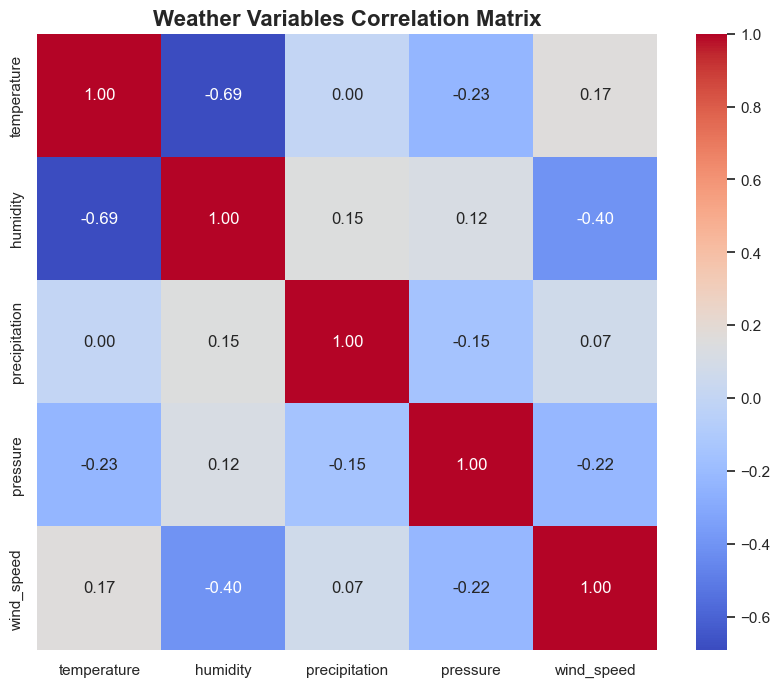

2025-06-21 04:15:48,857 - INFO - Insight: This heatmap quickly reveals relationships, e.g., the expected negative correlation between temperature and humidity.
2025-06-21 04:15:48,859 - INFO - PREPROCESSING 4.2: Cleaning and saving weather data.
2025-06-21 04:15:57,027 - INFO - ✅ Successfully saved processed weather data to ../../data/processed/hourly_weather.csv


In [30]:
# =============================================================================
# CELL 4.1: EDA - Correlation and Relationships
# =============================================================================
logger.info("EDA 4.1: Analyzing weather variable correlations.")

weather_vars = ['temperature', 'humidity', 'precipitation', 'pressure', 'wind_speed']
corr_matrix = df_weather[weather_vars].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Weather Variables Correlation Matrix', fontsize=16, weight='bold')
plt.show()
logger.info("Insight: This heatmap quickly reveals relationships, e.g., the expected negative correlation between temperature and humidity.")

# =============================================================================
# CELL 4.2: Preprocessing and Saving
# =============================================================================
logger.info("PREPROCESSING 4.2: Cleaning and saving weather data.")
# Similar imputation as with air quality data
df_weather[weather_vars] = df_weather.groupby('location')[weather_vars].transform(lambda x: x.ffill().bfill())
df_weather.dropna(inplace=True)

output_file = os.path.join(PROCESSED_DATA_PATH, 'hourly_weather.csv')
df_weather.to_csv(output_file)
logger.info(f"✅ Successfully saved processed weather data to {output_file}")

## 5. Merging Datasets & Cross-Analysis

This is where we combine the two primary datasets to explore how weather influences air quality.

In [34]:
# =============================================================================
# CELL 5: MERGING DATASETS & CROSS-ANALYSIS
# =============================================================================

# --- 5.1: Merge Air Quality and Weather Data ---
logger.info("MERGING 5.1: Combining processed air quality and weather data.")

# df_aq và df_weather đã có DatetimeIndex. Chúng ta reset nó để merge,
# sau đó đặt lại. Đây là cách làm chuẩn.
df_hourly_merged = pd.merge(
    df_aq.reset_index(), 
    df_weather.reset_index(), 
    on=['datetime', 'location'], 
    how='inner' # 'inner' join đảm bảo chỉ giữ lại các mốc thời gian có dữ liệu ở cả hai nguồn
)

# Sau khi merge, cột 'datetime' vẫn là timezone-aware. Chỉ cần đặt nó làm index.
df_hourly_merged.set_index('datetime', inplace=True)
logger.info(f"✅ Merged dataframe created with shape: {df_hourly_merged.shape}")
display(df_hourly_merged.head())


# --- 5.2: EDA - Air Quality vs. Weather ---
logger.info("EDA 5.2: Exploring relationship between weather and pollution.")

# Sử dụng một mẫu ngẫu nhiên để vẽ biểu đồ nhanh hơn, tránh treo máy với dữ liệu lớn
# Lấy mẫu sau khi đã merge để đảm bảo dữ liệu là đầy đủ
df_sample = df_hourly_merged.sample(n=min(5000, len(df_hourly_merged)), random_state=42)
logger.info(f"Using a sample of {len(df_sample)} records for plotting.")

# Biểu đồ 1: Gió vs. PM2.5
fig_scatter_wind = px.scatter(
    df_sample,
    x='wind_speed',
    y='pm2_5',
    trendline='lowess',  # Locally Weighted Scatterplot Smoothing rất tốt để thấy xu hướng phi tuyến
    title='<b>Relationship between Wind Speed and PM2.5</b>',
    labels={'wind_speed': 'Wind Speed (km/h)', 'pm2_5': 'PM2.5 (µg/m³)'},
    template='plotly_white'
)
fig_scatter_wind.update_layout(title_x=0.5)
fig_scatter_wind.show()
logger.info("Insight 1: The scatter plot with a LOWESS trendline shows a non-linear relationship. Generally, higher wind speeds help disperse pollutants, reducing PM2.5 levels.")

# Biểu đồ 2: Độ ẩm vs. PM2.5
fig_scatter_humidity = px.scatter(
    df_sample,
    x='humidity',
    y='pm2_5',
    color='temperature', # Thêm chiều thứ 3: màu sắc thể hiện nhiệt độ
    trendline='lowess',
    title='<b>Relationship between Humidity and PM2.5 (Colored by Temperature)</b>',
    labels={'humidity': 'Relative Humidity (%)', 'pm2_5': 'PM2.5 (µg/m³)', 'temperature': 'Temperature (°C)'},
    template='plotly_white'
)
fig_scatter_humidity.update_layout(title_x=0.5)
fig_scatter_humidity.show()
logger.info("Insight 2: This plot can reveal complex interactions. For example, high PM2.5 might occur at high humidity, especially when temperatures are low (foggy conditions) or high (smog formation).")

2025-06-21 04:20:34,013 - INFO - MERGING 5.1: Combining processed air quality and weather data.
2025-06-21 04:20:34,531 - INFO - ✅ Merged dataframe created with shape: (816224, 25)


location  latitude  longitude  timestamp_unix  \
datetime                                                                        
2020-11-25 19:00:00+11:00  Melbourne CBD  -37.8136   144.9631      1606266000   
2020-11-25 20:00:00+11:00  Melbourne CBD  -37.8136   144.9631      1606269600   
2020-11-25 21:00:00+11:00  Melbourne CBD  -37.8136   144.9631      1606273200   
2020-11-25 22:00:00+11:00  Melbourne CBD  -37.8136   144.9631      1606276800   
2020-11-25 23:00:00+11:00  Melbourne CBD  -37.8136   144.9631      1606280400   

                           aqi      co    no   no2     o3   so2  ...  \
datetime                                                         ...   
2020-11-25 19:00:00+11:00    2  220.30  1.87  6.51  85.12  7.15  ...   
2020-11-25 20:00:00+11:00    1  213.62  1.22  4.16  78.68  5.07  ...   
2020-11-25 21:00:00+11:00    1  213.62  1.05  3.81  77.96  4.65  ...   
2020-11-25 22:00:00+11:00    2  216.96  1.02  4.03  80.82  4.95  ...   
2020-11-25 23:00:00+11:00    2  226.97  1.12  5.23  90.84  6.20  ...   

                           pm10_aqi  pm2_5_aqi  o3_aqi  co_aqi  aqi_index  \
datetime                                                                    
2020-11-25 19:00:00+11:00       1.0        1.0     2.0     1.0        2.0   
2020-11-25 20:00:00+11:00       1.0        1.0     2.0     1.0        2.0   
2020-11-25 21:00:00+11:00       1.0        1.0     2.0     1.0        2.0   
2020-11-25 22:00:00+11:00       1.0        1.0     2.0     1.0        2.0   
2020-11-25 23:00:00+11:00       1.0        1.0     2.0     1.0        2.0   

                           temperature  humidity  precipitation  pressure  \
datetime                                                                    
2020-11-25 19:00:00+11:00         18.6        68            0.0    1009.9   
2020-11-25 20:00:00+11:00         20.8        61            0.0    1009.4   
2020-11-25 21:00:00+11:00         22.8        56            0.0    1008.6   
2020-11-25 22:00:00+11:00         25.1        51            0.0    1008.2   
2020-11-25 23:00:00+11:00         27.2        47            0.0    1007.3   

                           wind_speed  
datetime                               
2020-11-25 19:00:00+11:00         9.5  
2020-11-25 20:00:00+11:00         9.7  
2020-11-25 21:00:00+11:00         9.2  
2020-11-25 22:00:00+11:00         9.9  
2020-11-25 23:00:00+11:00         9.9  

[5 rows x 25 columns]

2025-06-21 04:20:34,552 - INFO - EDA 5.2: Exploring relationship between weather and pollution.
2025-06-21 04:20:34,670 - INFO - Using a sample of 5000 records for plotting.


2025-06-21 04:20:36,791 - INFO - Insight 1: The scatter plot with a LOWESS trendline shows a non-linear relationship. Generally, higher wind speeds help disperse pollutants, reducing PM2.5 levels.


2025-06-21 04:20:36,929 - INFO - Insight 2: This plot can reveal complex interactions. For example, high PM2.5 might occur at high humidity, especially when temperatures are low (foggy conditions) or high (smog formation).


## 6. Social Media Data - UOI Calculation

Now we process the unstructured text data from social media to create a daily signal of public perception.

2025-06-21 04:20:44,662 - INFO - UOI 6.1: Loading and combining all social media JSON files.
2025-06-21 04:20:44,694 - INFO - Loaded a total of 507 unique social media posts.
2025-06-21 04:20:44,697 - INFO - EDA 6.2: Analyzing social media content.


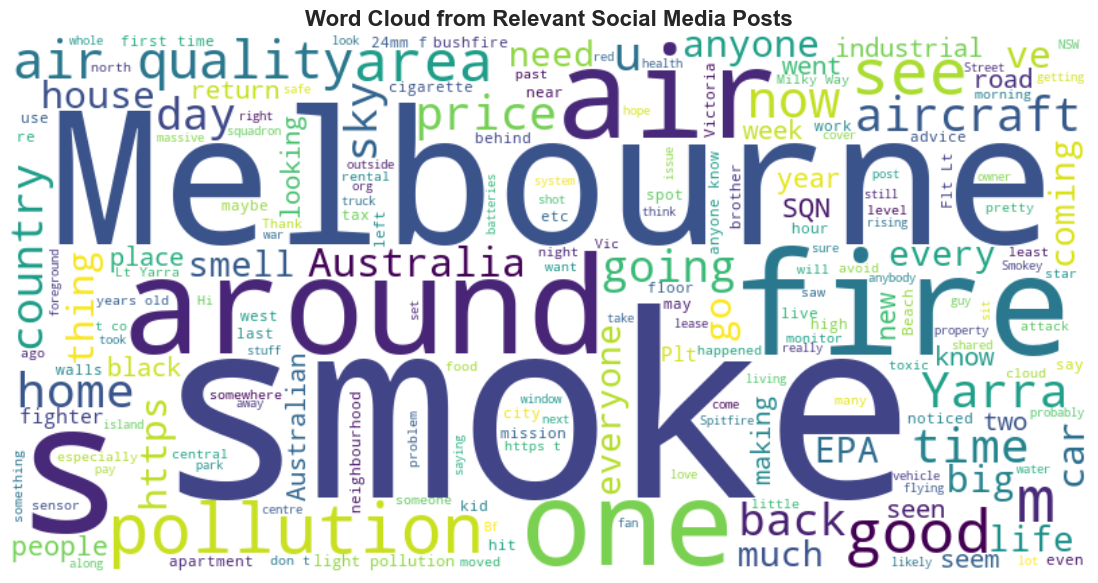

2025-06-21 04:20:45,503 - INFO - Insight: The word cloud highlights the most common terms used by the public when discussing air quality.
2025-06-21 04:20:45,505 - INFO - UOI 6.3: Calculating daily User Observations Index (UOI).
2025-06-21 04:20:45,516 - INFO - ✅ Successfully calculated and saved UOI to ../../data/processed/daily_uoi.csv


relevant_posts  total_posts       uoi
created_at                                                      
2025-06-16 00:00:00+00:00               1            1  0.999999
2025-06-17 00:00:00+00:00               0            0  0.000000
2025-06-18 00:00:00+00:00               2            3  0.666666
2025-06-19 00:00:00+00:00               5            6  0.833333
2025-06-20 00:00:00+00:00               1            1  0.999999

In [35]:
# =============================================================================
# CELL 6.1: Load and Combine Social Media Data
# =============================================================================
logger.info("UOI 6.1: Loading and combining all social media JSON files.")
all_social_data = []
for f in social_media_files:
    try:
        with open(f, 'r', encoding='utf-8') as file:
            all_social_data.extend(json.load(file))
    except json.JSONDecodeError:
        logger.warning(f"Could not decode JSON from {f}. File might be empty or corrupt. Skipping.")

if all_social_data:
    df_social = pd.DataFrame(all_social_data)
    df_social.drop_duplicates(subset=['id'], inplace=True)
    df_social['created_at'] = pd.to_datetime(df_social['created_at'], errors='coerce')
    logger.info(f"Loaded a total of {len(df_social)} unique social media posts.")
else:
    logger.warning("No social media data found to process.")
    df_social = pd.DataFrame() # Create empty df to avoid errors later

# =============================================================================
# CELL 6.2: EDA - Social Media Trends
# =============================================================================
if not df_social.empty:
    logger.info("EDA 6.2: Analyzing social media content.")
    # Combine title and text for a complete corpus
    df_social['full_text'] = df_social['title'].fillna('') + ' ' + df_social['text'].fillna('')
    
    # Simple check for relevant posts
    keywords = ['smoke', 'haze', 'smell burning', 'air quality', 'pollution']
    pattern = '|'.join(keywords)
    df_social['is_relevant'] = df_social['full_text'].str.contains(pattern, case=False)

    # Word Cloud of relevant posts
    relevant_text = ' '.join(df_social[df_social['is_relevant']]['full_text'])
    if relevant_text:
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(relevant_text)
        plt.figure(figsize=(15, 7))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud from Relevant Social Media Posts', fontsize=16, weight='bold')
        plt.show()
        logger.info("Insight: The word cloud highlights the most common terms used by the public when discussing air quality.")
    
# =============================================================================
# CELL 6.3: UOI Calculation and Saving
# =============================================================================
if not df_social.empty:
    logger.info("UOI 6.3: Calculating daily User Observations Index (UOI).")
    df_social_daily = df_social.set_index('created_at').resample('D')['is_relevant'].agg(['sum', 'count'])
    df_social_daily.rename(columns={'sum': 'relevant_posts', 'count': 'total_posts'}, inplace=True)
    
    # Calculate UOI: ratio of relevant posts to total posts. Add small epsilon to avoid division by zero.
    df_social_daily['uoi'] = df_social_daily['relevant_posts'] / (df_social_daily['total_posts'] + 1e-6)

    output_file = os.path.join(PROCESSED_DATA_PATH, 'daily_uoi.csv')
    df_social_daily.to_csv(output_file)
    logger.info(f"✅ Successfully calculated and saved UOI to {output_file}")
    display(df_social_daily.tail())

## 7. Final Merge & Feature Engineering

This final section creates the 'gold' dataset by merging all sources and engineering time-based features.

In [36]:
# =============================================================================
# CELL 7.1: Final Merge
# =============================================================================
# We need to bring the daily UOI into our hourly dataset. We'll map it by date.
logger.info("MERGING 7.1: Merging daily UOI into the hourly dataset.")
if 'df_social_daily' in locals():
    df_hourly_merged['date'] = df_hourly_merged.index.date
    df_social_daily.index = df_social_daily.index.date
    df_gold = pd.merge(df_hourly_merged, df_social_daily[['uoi']], left_on='date', right_index=True, how='left')
    df_gold['uoi'].fillna(0, inplace=True) # Fill NaNs for days with no social media data
    df_gold.drop(columns=['date'], inplace=True)
    logger.info("UOI merged successfully.")
else:
    df_gold = df_hourly_merged.copy()
    df_gold['uoi'] = 0
    logger.warning("No social media data, UOI column set to 0.")

# =============================================================================
# CELL 7.2: Feature Engineering - Time & Lag Features
# =============================================================================
logger.info("FEATURE ENGINEERING 7.2: Creating time-based and lag features.")
df_gold['hour'] = df_gold.index.hour
df_gold['day_of_week'] = df_gold.index.dayofweek
df_gold['month'] = df_gold.index.month

# Lag features (e.g., PM2.5 from 1, 2, 24 hours ago)
# Group by location to prevent data from one station lagging into another
for lag in [1, 2, 3, 24]:
    df_gold[f'pm2_5_lag_{lag}'] = df_gold.groupby('location')['pm2_5'].shift(lag)

# Rolling window features
df_gold['pm2_5_rolling_mean_24h'] = df_gold.groupby('location')['pm2_5'].transform(lambda x: x.rolling(window=24, min_periods=1).mean())

df_gold.dropna(inplace=True) # Drop rows with NaNs created by lag/rolling features
logger.info(f"Time, lag, and rolling features created. Final gold dataset shape: {df_gold.shape}")

# =============================================================================
# CELL 7.3: Save the Gold Dataset
# =============================================================================
output_file = os.path.join(GOLD_DATA_PATH, 'final_hourly_modeling_dataset.csv')
df_gold.to_csv(output_file)
logger.info(f"✅🥇 Gold dataset saved to {output_file}. Ready for modeling!")
display(df_gold.sample(5).T)

2025-06-21 04:20:53,748 - INFO - MERGING 7.1: Merging daily UOI into the hourly dataset.
2025-06-21 04:20:54,187 - INFO - UOI merged successfully.
2025-06-21 04:20:54,189 - INFO - FEATURE ENGINEERING 7.2: Creating time-based and lag features.
2025-06-21 04:20:55,067 - INFO - Time, lag, and rolling features created. Final gold dataset shape: (815672, 34)
2025-06-21 04:21:14,481 - INFO - ✅🥇 Gold dataset saved to ../../data/gold/final_hourly_modeling_dataset.csv. Ready for modeling!


datetime               2021-07-12 07:00:00+10:00 2022-10-19 06:00:00+11:00  \
location                                Werribee                  Brooklyn   
latitude                                -37.9009                  -37.8161   
longitude                                144.659                  144.8415   
timestamp_unix                        1626012000                1666094400   
aqi                                            1                         5   
co                                        211.95                    667.57   
no                                           0.0                     27.27   
no2                                         1.14                     84.31   
o3                                          44.7                      0.01   
so2                                          0.2                     15.26   
pm2_5                                       2.22                     62.02   
pm10                                        2.96                     72.09   
nh3                                          1.0                      8.49   
so2_aqi                                      1.0                       1.0   
no2_aqi                                      1.0                       3.0   
pm10_aqi                                     1.0                       3.0   
pm2_5_aqi                                    1.0                       4.0   
o3_aqi                                       1.0                       1.0   
co_aqi                                       1.0                       1.0   
aqi_index                                    1.0                       4.0   
temperature                                  8.9                      13.0   
humidity                                      84                        82   
precipitation                                0.0                       0.0   
pressure                                  1018.8                    1014.5   
wind_speed                                  15.7                       8.0   
uoi                                          0.0                       0.0   
hour                                           7                         6   
day_of_week                                    0                         2   
month                                          7                        10   
pm2_5_lag_1                                 3.23                     66.27   
pm2_5_lag_2                                 3.85                     66.02   
pm2_5_lag_3                                 3.92                     55.47   
pm2_5_lag_24                               18.38                      5.71   
pm2_5_rolling_mean_24h                  10.30375                 19.312917   

datetime               2022-01-06 20:00:00+11:00 2023-02-21 06:00:00+11:00  \
location                              Yarraville                  Brighton   
latitude                                -37.8167                  -37.9056   
longitude                                  144.9                  145.0028   
timestamp_unix                        1641434400                1676894400   
aqi                                            1                         1   
co                                        196.93                    180.24   
no                                          0.91                      0.01   
no2                                         6.34                      7.45   
o3                                         44.35                     28.61   
so2                                         4.89                      3.16   
pm2_5                                        0.8                       3.1   
pm10                                        1.14                      6.03   
nh3                                         1.41                      2.09   
so2_aqi                                      1.0                       1.0   
no2_aqi                                      1.0                       1.0   
pm10_aqi             